# Define PANORAMIC fields

The associations have been computed and the preprocessing executed elsewhere....


In [1]:
import jwst

In [20]:
! cat panoramic_fields.txt

# field        n   sx    sy   ra         dec         nx  ny  date       time
j090000p0207  80   4.0   6.5 135.004000    2.114070  3   5  2023-04-03 09:42:05.050
j093144p0819 120   4.7   6.7 142.941000    8.325030  4   5  2023-04-20 04:53:11.366
j093452p6116  80   5.9   6.5 143.708500   61.272400  5   5  2023-04-06 19:16:17.682
j094232p0923 120   4.9   6.7 145.630000    9.378995  4   5  2023-04-19 09:41:11.366
j100736p2109  60   5.2   6.7 151.906000   21.155250  4   5  2023-05-07 07:21:18.312
j123800p6217 430  17.0  15.7 189.485500   62.249400 13  12  2023-03-28 07:25:57.468
j125652p5652 240   6.4   3.8 194.211500   56.865700  5   3  2023-04-01 19:15:23.999
j145652p2444  40   5.3   6.7 224.223500   24.740000  4   5  2023-03-24 02:33:18.312
j150604p5409 160   6.5   7.1 226.514500   54.154800  5   6  2023-04-03 14:28:49.893
j153500p2325 240   3.6   6.4 233.742500   23.420000  3   5  2023-03-06 09:39:23.999
j170720p5853 120   4.9   6.9 256.841500   58.879350  4   6  2023-02-18 00:03:56.209

In [21]:
# Which mosaics hae been made?
! cat mosaic_log.txt

# field  version date time
j090000p0207  v6.0  2023-05-04 09:44:57.191
j145652p2444  v6.0  2023-05-04 10:37:56.604
j093144p0819  v6.0  2023-05-04 11:16:46.528
j100736p2109  v6.0  2023-05-10 16:07:03.162
j093452p6116  v6.0  2023-05-10 18:43:31.732
j125652p5652  v6.0  2023-05-10 18:44:39.470
j150604p5409  v6.0  2023-05-10 19:45:12.123
j170720p5853  v6.0  2023-05-10 20:00:33.283
j094232p0923  v6.0  2023-05-10 20:12:52.988


In [4]:
import os
import gc
import glob

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import astropy.wcs as pywcs
import astropy.time

from grizli.aws import db, visit_processor
from grizli import utils, prep
from grizli.pipeline import auto_script

from mastquery import overlaps

Set ROOT_PATH=/work
`import jwst` failed so JWST processing will not work!


In [5]:
def create_s3_index(path, output_file="index.html", extra_html="", upload=True):
    """
    Create HTML listing of an S3 path
    """
    import time

    url = path.replace('s3://', 'https://s3.amazonaws.com/')

    lsfile = output_file.replace('.html','.ls')

    # Sort by filename
    sort_str = 'sort -k 4'

    os.system(f'aws s3 ls {path} | {sort_str} |grep -v PRE |grep -v {output_file} > {lsfile}')

    now = time.ctime()
    html=f"<h3>{now}</h3>\n"

    html += extra_html

    html += "\n<pre>\n"
    
    lines=open(lsfile).readlines()
    for line in lines:
        lsp = line.split()
        if len(lsp) == 4:
            html += "{0} {1} {2:>10} <a href={4}{3} > {3} </a>\n".format(*lsp, url)

    html += '</pre>\n'
    fp = open(output_file,'w')
    fp.write(html)
    fp.close()
    
    if upload:
        os.system(f'aws s3 cp {output_file} {path} --acl public-read')
        print(path.replace('s3://', 'https://s3.amazonaws.com/') + output_file)

    print(output_file)


## Query database for exposure footprints

In [6]:
# Query the grizli database for processed exposures
program_id = 2514 # Panoramic

res = db.SQL(f"""select assoc, dataset, filter,
crval1 as ra, crval2 as dec, footprint as coords,
expstart as t_min, exptime, detector, instrume
from exposure_files where (dataset like 'jw{program_id:05d}%%')
""")

len(res)


1690

In [7]:
# Group by "parent" defined when associations were generated
res['parent'] = [a.split('_')[0] for a in res['assoc']]
res['parent-filt'] = [a.split('_')[0] + '-' + f
                      for a, f in zip(res['assoc'], res['filter'])]
                      
un = utils.Unique(res['parent'])

   N  value     
====  ==========
  40  j145652p2444
  60  j100736p2109
  80  j090000p0207
  80  j093452p6116
 120  j093144p0819
 120  j094232p0923
 120  j170720p5853
 160  j150604p5409
 240  j125652p5652
 240  j153500p2325
 430  j123800p6217


# field        n   sx    sy   ra         dec         nx  ny  date       time
j090000p0207  80   4.0   6.5 135.004000    2.114070  3   5  2023-04-03 09:42:05.050
j093144p0819 120   4.7   6.7 142.941000    8.325030  4   5  2023-04-20 04:53:11.366
j093452p6116  80   5.9   6.5 143.708500   61.272400  5   5  2023-04-06 19:16:17.682
j094232p0923 120   4.9   6.7 145.630000    9.378995  4   5  2023-04-19 09:41:11.366
j100736p2109  60   5.2   6.7 151.906000   21.155250  4   5  2023-05-07 07:21:18.312
j123800p6217 430  17.0  15.7 189.485500   62.249400 13  12  2023-03-28 07:25:57.468
j125652p5652 240   6.4   3.8 194.211500   56.865700  5   3  2023-04-01 19:15:23.999
j145652p2444  40   5.3   6.7 224.223500   24.740000  4   5  2023-03-24 02:33:18.312
j150604p5409 160   6.5   7.1 226.514500   54.154800  5   6  2023-04-03 14:28:49.893
j153500p2325 240   3.6   6.4 233.742500   23.420000  3   5  2023-03-06 09:39:23.999
j170720p5853 120   4.9   6.9 256.841500   58.879350  4   6  2023-02-18 00:03:56.209

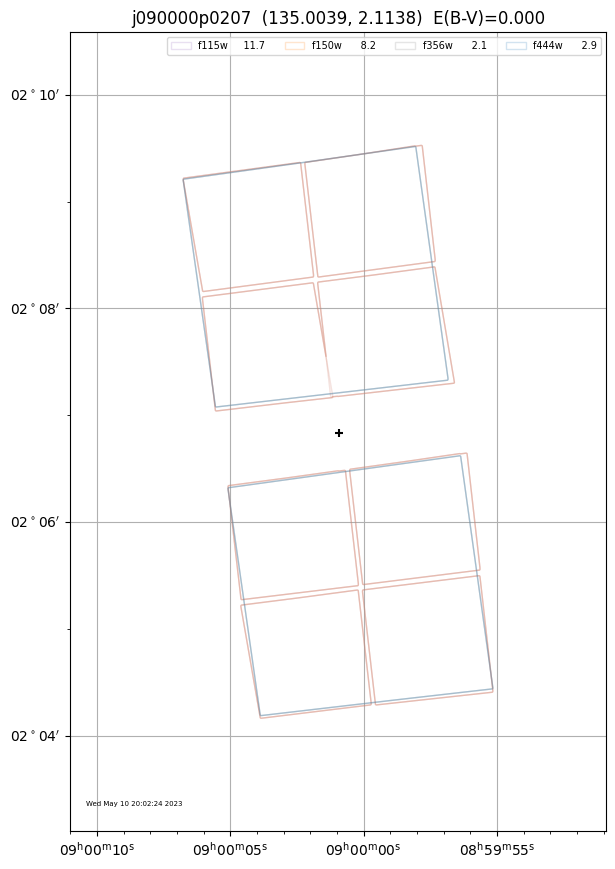

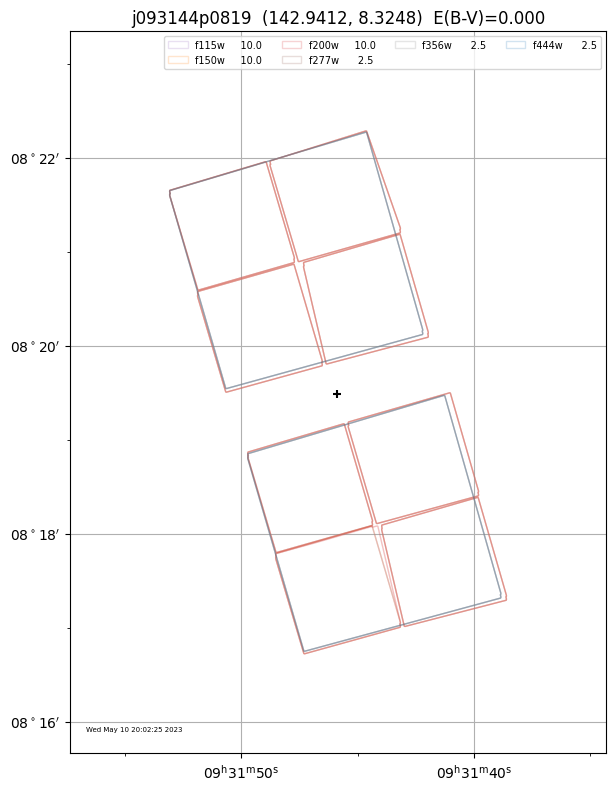

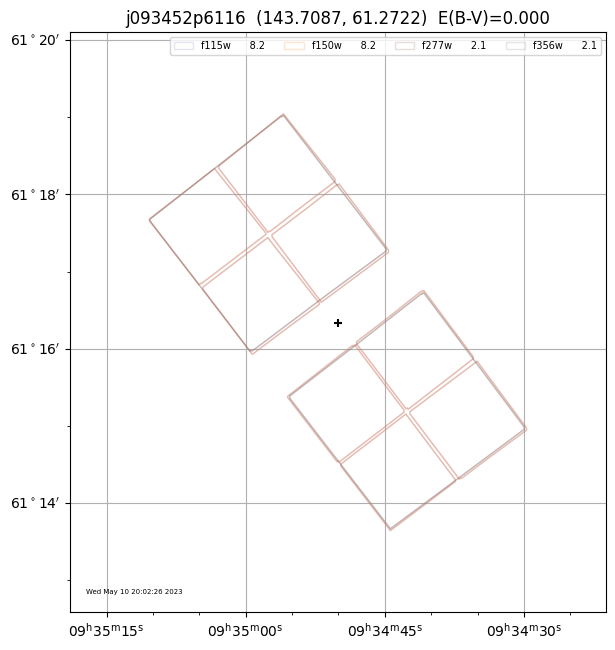

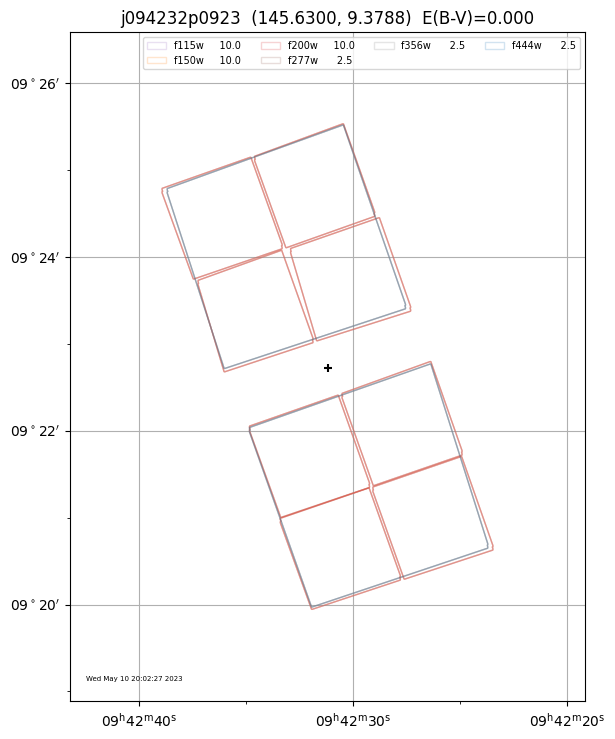

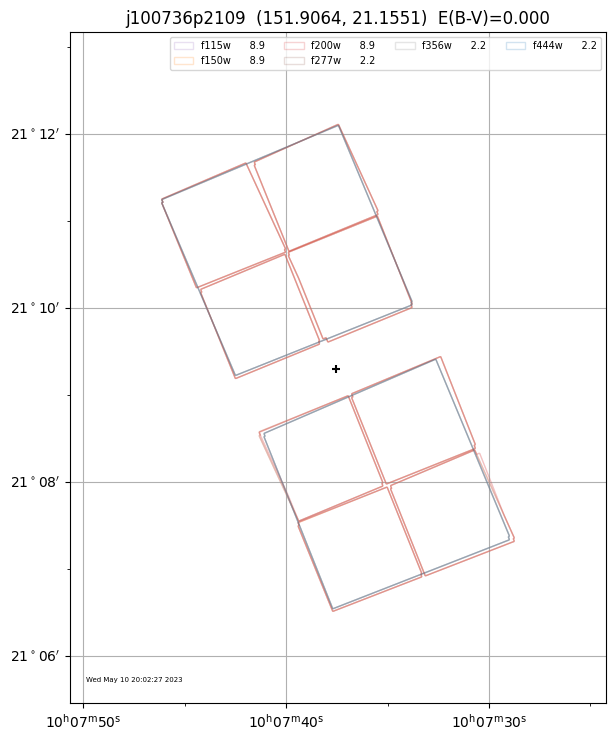

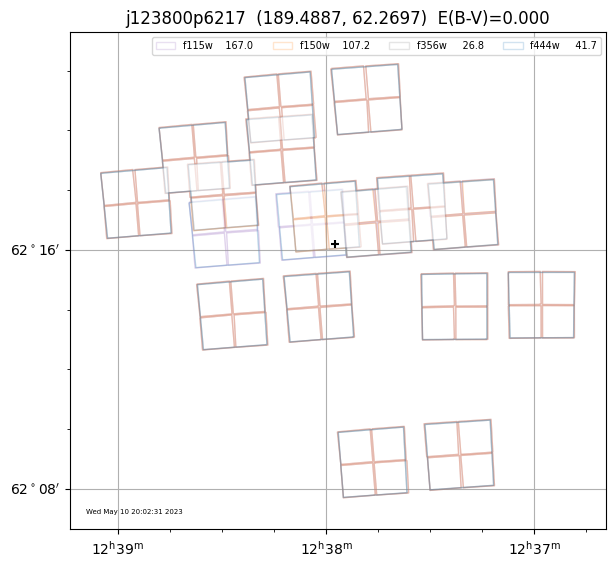

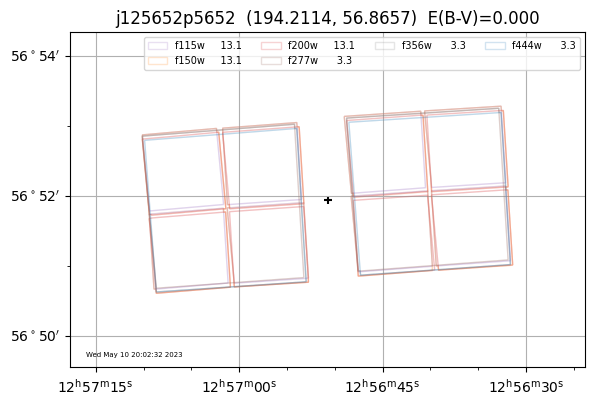

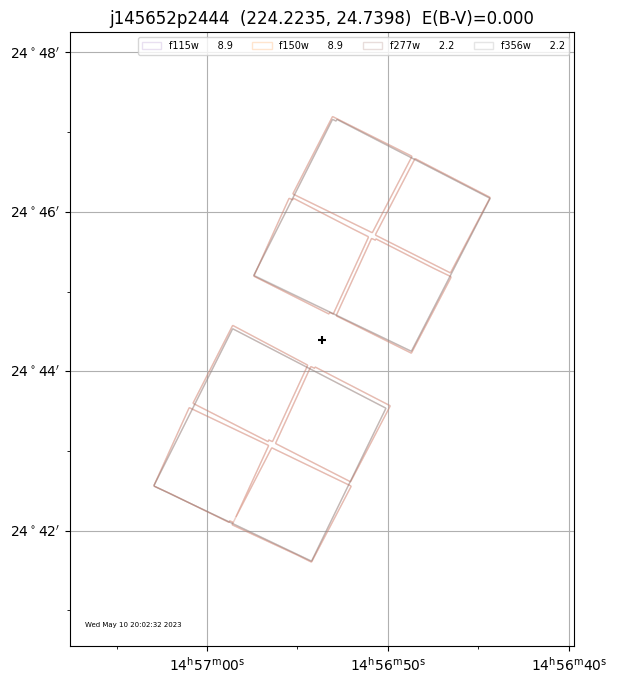

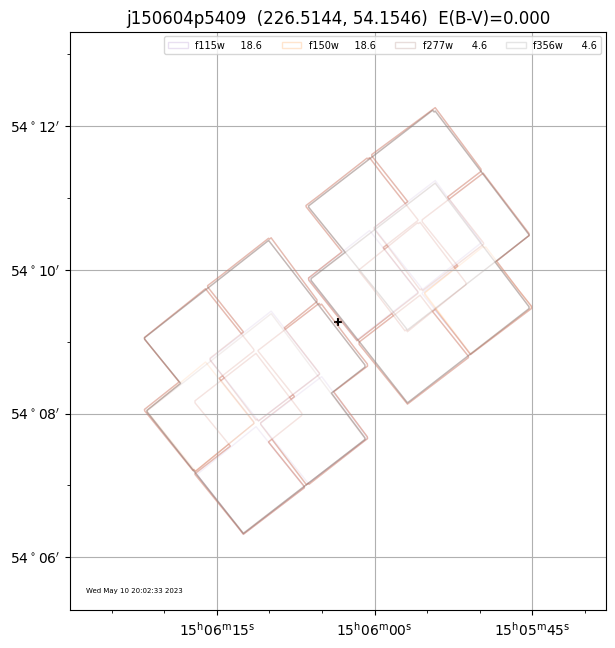

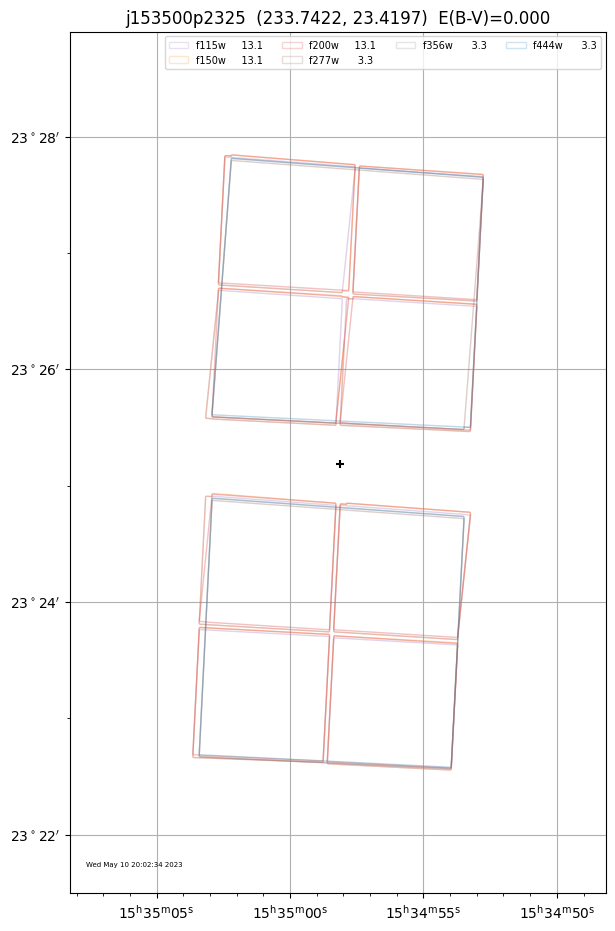

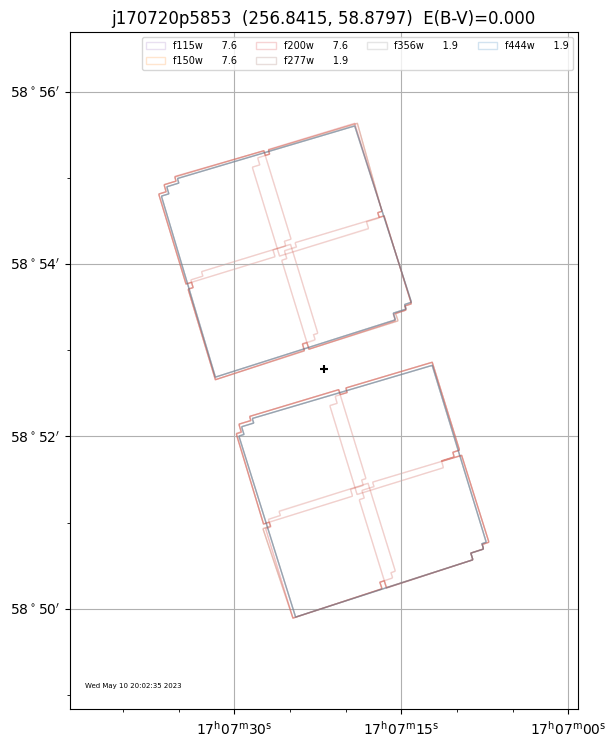

In [8]:
row = '# field        n   sx    sy   ra         dec         nx  ny  date       time'
with open('panoramic_fields.txt','w') as fp:
    fp.write(row+'\n')

print(row)

for field in un.values:
    rf = res[un[field]]
    
    # Things needed for the plot script
    rf.meta['NAME'] = field
    rf.meta['RA'] = np.mean(rf['ra'])
    rf.meta['DEC'] = np.mean(rf['dec'])
    rf.meta['MW_EBV'] = 0.0
    
    rf['obs_id'] = rf['dataset']
    rf['proposal_id'] = [int(d[3:7]) for d in rf['dataset']]
    rf['t_max'] = rf['t_min'] + rf['exptime']/86400.
    rf['instrument_name'] = rf['instrume']
    rf['target'] = 'indef'
    rf['filter'] = [f.split('-')[0] for f in rf['filter']]
    rf['footprint'] = [f'POLYGON {f.replace("(","").replace(")","").replace(","," ")}'
                       for f in rf['coords']]

    _ = overlaps.split_associations(rf, assoc_min=0, 
                                        #assoc_args=assoc_args,
                                        force_split=True,
                                        with_ls_thumbnail=False,
                                        xsize=6,
                                        )
                                        #ls_args=LS_ARGS)
    
    tab = _[0]
    fig = _[1]
    fig.savefig(f'panoramic-{field}.png')
    
    # size: the plot window is a box containing the exposures padded by 1arcmin
    cosd = np.cos(rf.meta['DEC']/180*np.pi)
    sx = (rf.meta['XMAX'] - rf.meta['XMIN'])*cosd*60-1
    sy = (rf.meta['YMAX'] - rf.meta['YMIN'])*60-1
    
    # Center of the plot as center ra/dec
    ra0 = (rf.meta['XMAX'] + rf.meta['XMIN'])/2.
    de0 = (rf.meta['YMAX'] + rf.meta['YMIN'])/2.
    
    # Size in units of 2048 x 40mas/pixel 
    nx = int(np.ceil(sx/(2048*0.04/60)))
    ny = int(np.ceil(sy/(2048*0.04/60)))

    tmax = astropy.time.Time(rf['t_max'].max(), format='mjd').iso

    row = f"{field:12} {un[field].sum():>3} {sx:5.1f} {sy:5.1f} {ra0:10.6f}  {de0:10.6f} {nx:>2}  {ny:>2}  {tmax}"
    with open('panoramic_fields.txt','a') as fp:
        fp.write(row+'\n')

    print(row)

## Run mosaics, catalogs

In [9]:
# Set version

mosaic_version = 'v6.0' # latest grizli (May 2023)

In [10]:
# Work in /scratch on the root filesystem if expect to make more than 5 GB of files.
# NB: files here won't be saved when the machine is shut down!

# hmm, but doesn't seem to work
if 0:
    work_path = '/scratch'
    if not os.path.exists(work_path):
        os.makedirs(work_path)
    
else:
    work_path = '/work'

os.chdir(work_path)
print(f'Working directory: {work_path}')

! df -h . 

Working directory: /work
Filesystem                                                          Size  Used Avail Use% Mounted on
172.2.196.10:/projects-pool/p-a56be2b0-05e9-4804-afc1-e2fa4997b5d9  5.0G  330M  4.7G   7% /work


In [11]:
fields = utils.read_catalog('/work/panoramic_fields.txt')
fields.to_pandas()

,field,n,sx,sy,ra,dec,nx,ny,date,time
0,j090000p0207,80,4.0,6.5,135.0040,2.114070,3,5,2023-04-03,09:42:05.050
1,j093144p0819,120,4.7,6.7,142.9410,8.325030,4,5,2023-04-20,04:53:11.366
2,j093452p6116,80,5.9,6.5,143.7085,61.272400,5,5,2023-04-06,19:16:17.682
3,j094232p0923,120,4.9,6.7,145.6300,9.378995,4,5,2023-04-19,09:41:11.366
4,j100736p2109,60,5.2,6.7,151.9060,21.155250,4,5,2023-05-07,07:21:18.312
5,j123800p6217,430,17.0,15.7,189.4855,62.249400,13,12,2023-03-28,07:25:57.468
6,j125652p5652,240,6.4,3.8,194.2115,56.865700,5,3,2023-04-01,19:15:23.999
7,j145652p2444,40,5.3,6.7,224.2235,24.740000,4,5,2023-03-24,02:33:18.312
8,j150604p5409,160,6.5,7.1,226.5145,54.154800,5,6,2023-04-03,14:28:49.893
9,j153500p2325,240,3.6,6.4,233.7425,23.420000,3,5,2023-03-06,09:39:23.999


In [22]:
# Make a mosaic

LW_FILTERS = ['F277W-CLEAR','F356W-CLEAR','F444W-CLEAR',
              'F335M-CLEAR','F410M-CLEAR','F460M-CLEAR','F480M-CLEAR']

SW_FILTERS = ['F070W-CLEAR','F090W-CLEAR', 'F115W-CLEAR',
              'F150W-CLEAR','F200W-CLEAR', 'F210M-CLEAR' ]

WFC3IR_FILTERS = ['F160W','F140W','F125W','F110W','F105W','F098M']

ACS_FILTERS = ['F850LP','F814W','F606W','F435W','F438W','F775W']

for field in ['j153500p2325']:

    ix = np.where(fields['field'] == field)[0][0]

    pixel_scale = 0.04 # arcsec/pix

    hdu = utils.make_wcsheader(fields['ra'][ix], fields['dec'][ix],
                               size=(fields['nx'][ix]*2048*pixel_scale,
                                     fields['ny'][ix]*2048*pixel_scale),
                               pixscale=0.04, get_hdu=True)

    
    ir_wcs = pywcs.WCS(hdu.header)
    
    # Pull files from AWS and drizzle into a mosaic
    # NB: this will pull *any* exposure that overlaps with the defined WCS, 
    #     not just PANORAMIC from the query above. 

    root = f'panoramic-{field}-{mosaic_version}'
    for filt in LW_FILTERS:
        _ = visit_processor.cutout_mosaic(rootname=root,
                                      ir_wcs=ir_wcs,
                                      clean_flt=True,
                                      filters=[filt],
                                      half_optical=False,
                                      s3output=None,
                                      pixfrac=0.75,
                                      kernel='square',
                                      skip_existing=True,
                                      )
        gc.collect()
        # ! gzip {root}*{filt.lower()}*fits

    # SW run in a slightly weird way for memory issues?
    for filt in SW_FILTERS:
        _ = visit_processor.cutout_mosaic(rootname=root,
                                      ir_wcs=ir_wcs,
                                      clean_flt=True,
                                      filters=[filt],
                                      half_optical=True,
                                      s3output=None,
                                      pixfrac=0.75,
                                      kernel='square',
                                      skip_existing=True,
                                      )
        gc.collect()
        ! gzip {root}*{filt.lower()}*fits

    # HST at 40mas, just in case
    for filt in WFC3IR_FILTERS + ACS_FILTERS:
        _ = visit_processor.cutout_mosaic(rootname=root,
                                      ir_wcs=ir_wcs,
                                      clean_flt=True,
                                      filters=[filt],
                                      half_optical=False,
                                      s3output=None,
                                      pixfrac=0.75,
                                      kernel='square',
                                      skip_existing=True,
                                      )



  (fetch from s3://grizli-v2/HST/Pipeline/j153500p2325_indef-f150w_00011/Prep/jw02514012001_06201_00002_nrcb3_rate.fits)
Use extra badpix in /usr/local/lib/python3.10/site-packages/grizli/data/nrc_lowpix_0916_NRCB3.fits.gz
Extra -5 sigma low pixels: N= 168  ( 0.004 %)
get_photom_scale /usr/local/lib/python3.10/site-packages/grizli/data/photom_correction.yml: NRCB3-F150W-CLEAR not found
  0    PHOTFLAM=2.97e-21, scale=1.000
  ext (SCI,1), sky=0.223 has_bkg:True
       PHOTFLAM=2.97e-21, scale=0.977
# (2023-05-10 20:23:25.334)
Drizzle array 1/1

(  48/  64) Add exposure jw02514012001_06201_00002_nrcb4_rate.fits

  (fetch from s3://grizli-v2/HST/Pipeline/j153500p2325_indef-f150w_00012/Prep/jw02514012001_06201_00002_nrcb4_rate.fits)
Use extra badpix in /usr/local/lib/python3.10/site-packages/grizli/data/nrc_lowpix_0916_NRCB4.fits.gz
Extra -5 sigma low pixels: N= 325  ( 0.008 %)
get_photom_scale /usr/local/lib/python3.10/site-packages/grizli/data/photom_correction.yml: NRCB4-F150W-CLEAR no

### RGB image

In [13]:
# RGB mosaic
def make_rgb(root, full_dimensions=2, scl=2.0):
    """
    Make RGB image
    """

    files = glob.glob(f"{root}*-f*clear*sci.fits*")
    files.sort()    

    filters = [f.split('-')[-2] + '-clear' for f in files]
    filters.sort()
    print(filters)

    auto_script.IMSAVE_QUALITY = 99

    norm = {'stretch': 'asinh', 'min_cut': -0.01, 
                                            'max_cut': 5.0, 'clip':True, 
                                            'asinh_a':0.010}

    im = pyfits.open(files[-1])

    msk = im[0].data != 0
    yp , xp = np.indices(msk.shape)
    spad = 64
    xyslice = (slice(np.maximum(xp[msk].min()-spad, 0), xp[msk].max()+spad), 
                slice(np.maximum(yp[msk].min()-spad, 0), yp[msk].max()+spad))

    print('slice: ', xyslice)

    filts = ['f356w-clear','f150w-clear','f115w-clear']
    rgb_scl = [1.0, 0.95, 1.02]

    if 'f444w-clear' in filters:
        filts = ['f444w-clear','f277w-clear','f115w-clear']

    rgb = auto_script.field_rgb(root,
                            HOME_PATH=None, gzext='*', 
                            filters=filts,
                            force_rgb=filts,
                            rgb_scl=rgb_scl,
                            full_dimensions=full_dimensions,
                            scl=scl,
                            suffix='.rgb',
                            xsize=128,
                            xyslice=xyslice,
                            add_labels=False,
                            norm_kwargs=norm,
                            output_format='png',
                            fill_black=True,
                            pl=2.0, pf=1)

    plt.close('all')


if not os.path.exists(f'{root}.rgb.png'):
    make_rgb(root, full_dimensions=2, scl=2.0)
else:
    print('RGB image found')
    

['f115w-clear', 'f150w-clear', 'f200w-clear', 'f277w-clear', 'f356w-clear', 'f444w-clear']
slice:  (slice(1256, 6935, None), slice(939, 9322, None))
PATH: ./, files: ['./panoramic-j094232p0923-v6.0-f200w-clear_drc_sci.fits.gz', './panoramic-j094232p0923-v6.0-f444w-clear_drc_sci.fits', './panoramic-j094232p0923-v6.0-f115w-clear_drc_sci.fits.gz', './panoramic-j094232p0923-v6.0-f277w-clear_drc_sci.fits', './panoramic-j094232p0923-v6.0-f150w-clear_drc_sci.fits.gz', './panoramic-j094232p0923-v6.0-f356w-clear_drc_sci.fits']
# field_rgb panoramic-j094232p0923-v6.0: r f444w-clear / g f277w-clear / b f115w-clear
# field_rgb scl=2.00 / r 1.00 / g 0.95 / b 1.02
# field_rgb norm with {'stretch': 'asinh', 'min_cut': -0.01, 'max_cut': 5.0, 'clip': True, 'asinh_a': 0.01}


### Detection image and catalog

LW detection image weighted by constant Fnu

Photometric catalog tends to run out of disk space...


In [14]:
from grizli.pipeline import auto_script
from grizli import prep
import astropy.io.fits as pyfits

comb = {'ir':['F444W-CLEAR','F356W-CLEAR','F277W-CLEAR',
              'F430M-CLEAR','F460M-CLEAR','F480M-CLEAR', 
              'CLEARP-F277W','CLEARP-F356W', 'CLEARP-F444W']}

block_filters = ['F090W-CLEAR','F115W-CLEAR','F150W-CLEAR','F200W-CLEAR']
    
for field in fields['field']:
    root = f'panoramic-{field}-{mosaic_version}'

    files = glob.glob(f'{root}*sci.fits*')
    if len(files) == 0:
        continue
    
    if len(glob.glob(f'{root}-ir_drc_sci.fits*')) == 0:
        status = auto_script.make_filter_combinations(root,
                                                  filter_combinations=comb, 
                                                  weight_fnu=2, 
                                                  force_photfnu=1.e-8,
                                                  block_filters=block_filters
                                                 )
    
    # Make the photometric catalog
    phot_apertures = prep.SEXTRACTOR_PHOT_APERTURES_ARCSEC[:4]
    
    # Skip catalogs for now, since they make "bkg" images that fill up the disk quota
    if (not os.path.exists(f'{root}_phot.fits')) & False:
        try:
            auto_script.multiband_catalog(field_root=root, 
                                      threshold=1.2, 
                                      bkg_params={'bw': 50, 'bh': 50,
                                                  'fw': 3, 'fh': 3,
                                                  'pixel_scale': pixel_scale}, 
                                      get_all_filters=True,
                                      phot_err_scale=1.0, 
                                      phot_apertures=phot_apertures,
                                      )
    
            phot = utils.read_catalog(f'{root}_phot.fits')
        except OSError:
            pass

        ! rm {root}*bkg.fits
        ! gzip {root}*seg.fits

panoramic-j094232p0923-v6.0-f277w-clear_drc_sci.fits f277w-clear ir block_reduce=False scl=1.0 scl_wht=1.0
panoramic-j094232p0923-v6.0-f356w-clear_drc_sci.fits f356w-clear ir block_reduce=False scl=1.0 scl_wht=1.0
panoramic-j094232p0923-v6.0-f444w-clear_drc_sci.fits f444w-clear ir block_reduce=False scl=1.0 scl_wht=1.0
Write panoramic-j094232p0923-v6.0-ir_drc_sci.fits


### Sync to S3

In [23]:
import astropy.time

for field in fields['field']:
    root = f'panoramic-{field}-{mosaic_version}'

    files = glob.glob(f'{root}*sci.fits*')
    if len(files) == 0:
        continue

    # Upload to S3
    ! rm {root}*bkg.fits

    files = glob.glob(f'{root}*_dr*fits')
    files += glob.glob(f'{root}*seg.fits')
    files.sort()
    
    for file in files:
        print(f'gzip {file}')
        ! gzip {file}

    s3path = f's3://grizli-panoramic/mosaics/{mosaic_version}/{field}/'

    ! aws s3 sync ./ {s3path} --exclude "*" --include "{root}*gz" --include "{root}*csv" --include "{root}*phot.fits" --include "{root}*cat.fits" --include "*{field}*png" --acl public-read

    extra_html = f"<img src=panoramic-{field}.png height=400px> <img src={root}.rgb.png height=400px> \n<br>"

    filter_files = glob.glob(f'{root}*fp.png')
    filter_files.sort()
    for file in filter_files:
        extra_html += f"<img src={file} height=200px>\n"

    extra_html += "<pre>\n# filter  expstart  ndrizim  exptime\n"
    files = glob.glob(f'{root}-f*_dr*sci.fits.gz')
    files.sort()
    for file in files:
        with pyfits.open(file) as im:
            expfact = 1.
            if im[0].header['INSTRUME'] == 'NIRCAM':
                if im[0].header['DETECTOR'] in ['NRCALONG','NRCBLONG']:
                    expfact = 2
                else:
                    expfact = 8

            row = f"{im[0].header['FILTER']} {im[0].header['EXPSTART']:.2f}  {im[0].header['NDRIZIM']//expfact}  {im[0].header['EXPTIME']/expfact:.1f}"

            print(row)
            extra_html += row + '\n'

    extra_html += f"</pre>\n"

    create_s3_index(s3path, output_file="index.html", extra_html=extra_html, upload=True)
    
    # Add to log
    log = utils.read_catalog('mosaic_log.txt')
    done = (log['field'] == field) & (log['version'] == mosaic_version)
    if done.sum() == 0:
        print(f'Add {field} {mosaic_version} to log.')

        with open('mosaic_log.txt','a') as fp:
            fp.write(f'{field}  {mosaic_version}  {astropy.time.Time.now().iso}\n')
    


rm: cannot remove 'panoramic-j153500p2325-v6.0*bkg.fits': No such file or directory
gzip panoramic-j153500p2325-v6.0-f277w-clear_drc_sci.fits
gzip panoramic-j153500p2325-v6.0-f277w-clear_drc_wht.fits
gzip panoramic-j153500p2325-v6.0-f356w-clear_drc_sci.fits
gzip panoramic-j153500p2325-v6.0-f356w-clear_drc_wht.fits
gzip panoramic-j153500p2325-v6.0-f444w-clear_drc_sci.fits
gzip panoramic-j153500p2325-v6.0-f444w-clear_drc_wht.fits
upload: ./panoramic-j153500p2325-v6.0-f150w-clear_fp.png to s3://grizli-panoramic/mosaics/v6.0/j153500p2325/panoramic-j153500p2325-v6.0-f150w-clear_fp.png
upload: ./panoramic-j153500p2325-v6.0-f115w-clear_wcs.csv to s3://grizli-panoramic/mosaics/v6.0/j153500p2325/panoramic-j153500p2325-v6.0-f115w-clear_wcs.csv
upload: ./panoramic-j153500p2325-v6.0-f115w-clear_fp.png to s3://grizli-panoramic/mosaics/v6.0/j153500p2325/panoramic-j153500p2325-v6.0-f115w-clear_fp.png
upload: ./panoramic-j153500p2325-v6.0-f150w-clear_wcs.csv to s3://grizli-panoramic/mosaics/v6.0/j1535

## Master HTML log for all processed mosaics

Don't delete `mosaic_log.txt` if clearing out files to make space!

In [24]:
! cat mosaic_log.txt

# field  version date time
j090000p0207  v6.0  2023-05-04 09:44:57.191
j145652p2444  v6.0  2023-05-04 10:37:56.604
j093144p0819  v6.0  2023-05-04 11:16:46.528
j100736p2109  v6.0  2023-05-10 16:07:03.162
j093452p6116  v6.0  2023-05-10 18:43:31.732
j125652p5652  v6.0  2023-05-10 18:44:39.470
j150604p5409  v6.0  2023-05-10 19:45:12.123
j170720p5853  v6.0  2023-05-10 20:00:33.283
j094232p0923  v6.0  2023-05-10 20:12:52.988
j153500p2325  v6.0  2023-05-10 20:30:53.549


In [25]:

log = utils.read_catalog('mosaic_log.txt')

un = utils.Unique(log['version'])

with open('mosaics.html','w') as fp:
    for v in un.values:
        fp.write(f'<h3> Version {v} </h3>\n')

        for i in np.where(un[v])[0]:
            s3 = f"https://s3.amazonaws.com/grizli-panoramic/mosaics/{v}/{log['field'][i]}/index.html"
            fp.write(f"{log['date'][i]} {log['time'][i]} <a href=\"{s3}\" /> {log['field'][i]} </a> <br> \n")

    fp.write(f'<h3> Fields </h3>\n')
    for field in fields['field']:
        fp.write(f'<p> {field} </p> <img src=panoramic-{field}.png height=300px /> \n')

! aws s3 sync ./ s3://grizli-panoramic/mosaics/ --exclude "*" --include "mosaics.html" --include "panoramic*png" --exclude "*fp.png" --acl public-read



   N  value     
====  ==========
  10  v6.0      
upload: ./mosaics.html to s3://grizli-panoramic/mosaics/mosaics.html


In [26]:
!df -h . 

Filesystem                                                          Size  Used Avail Use% Mounted on
172.2.196.10:/projects-pool/p-a56be2b0-05e9-4804-afc1-e2fa4997b5d9  5.0G  2.5G  2.6G  49% /work


## Cleanup

In [27]:
! rm panoramic*fits* panoramic*fp.png panoramic*wcs.csv panoramic*rgb.png

rm: cannot remove 'panoramic*rgb.png': No such file or directory


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a56be2b0-05e9-4804-afc1-e2fa4997b5d9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>